# Examining the Representativeness of OSM Bicycle Facilities  in U.S. Cities

Chester Harvey


## Introduction

[OpenStreetMap](https://www.openstreetmap.org/) (OSM) is an attractive data source for city planners due to its global coverage and rich attributes. In theory, this provides an efficient platform for conducting analyses across diverse geographies. Using locally-sourced data, for example, a project aiming to study a handful cities would have to access seperate data clearinghouses for each city, identify relevent datasets, and manage each of their unique data schemas. With OSM, by contrast, data collection might be simplified to a simple spatial query: *select streets within the boundary of each city*. In practice, however,  the richness and internal consistency of OSM data can vary substantially depending on the communities of individual and institutional contributors who "build out" the map in their own localles. Some types of features, such as highway geometries and their basic classifications tend to be well-represented across whole countries, usually owing to bulk imports from national datasets. [TIGER roadways](https://wiki.openstreetmap.org/wiki/TIGER), for example, were bulk imported in 2007, providing a dependable base network of roadways throughout the U.S. Contributors have since modified the TIGER geometries, added newly-constructed roadways, and added considerable attribute information, including tags related to lane configuration, parking, speed limits, bike facilities, sidewalks, traffic signals, and other characteristics. Though some cities and states have performed bulk imports, the majority of such updates have been made piecemeal, by individual users. This has resulted in substantially uneven distributions of attributes, with the bulk of editing occuring in [major cities](http://mapbox.github.io/osm-analysis-collab/editor-density?yearIdx=11&layer=0&minUsers=1&minObjects=1&#3/37.97/-105.59).

This project aims to evaluate the representativness of OSM data for transportation planning by comparing OSM and locally-sourced data for bicycle facilities. These facilities provide an apt benchmark for assessing OSM for several reasons. Firstly, they were not included in the nationwide TIGER import, so they are the product of more conventional contributions by individuals or local agencies. Secondly, they include both attribute additions to (presumably prexisting) roadway geometries (e.g., adding a bike lane tag) and new geometry additions (e.g., an off street path). Thirdly, there are currently no reliable national datasets of bicycle facilities, and OSM has significant potential to become the leading platform for mapping these facilities. It is, therefore, important to understand how well it performs in this regard, and ways that its representativeness can be improved.

Methodologically, this project has three core components.

1. Parse bicycle facilities from raw OSM data
2. Spatially join local bicycle facility data to OSM geometries
3. Examine agreement between OSM and local bicycle facility locations and types

Analysis for each of these components is documented below.

## Assignment Checklist 

All of the following:
- Some form of data access :: *Cells 6-7*
- Data tidying preparation :: *Cells 15-17*
- Initial data visualization :: *Cells 17, 25*
- Use of GitHub :: *See GitHub repo*
- Reproducible execution with use of Travis :: *See badge on GitHub README*
- Markdown writeup, with final submission as a nicely formatted PDF document that includes code and results :: *See GitHub repo*
- Overall clean and clear presentation of repository, code, and explanations :: *Across full document and GitHub repo*

At least three of the following:
- Use of at least 5 `dplyr` verbs / functions :: *Pandas/GeoPandas methods substituted; e.g., cells 49, 50* 
- Writing / working with custom functions :: *See most cells*
- Creating a package for functions used in the analysis :: *See `osm`, `conflation`, and `compare_bikeways` namespaces*
- Interaction with an API - Use of regular expressions :: *API: e.g., cell 8; regex: e.g., cell 13*
- Parsing extensible data formats (JSON, XML) :: *e.g., cell 15*
- Use of spatial vector data and visualization of spatial data :: *almost every cell*
- Use of `purrr` package functions for iteration :: *similar concept: `applymap` (e.g., cell 19) and `apply` (e.g., cell 21) methods*
- Manipulation of dates or strings :: *e.g., cell 15*
- Unique challenges you encounter: particularly messy data/ non-standard formats, special emphasis on visualization or presentation of results :: *The whole project is about messy data*

## 1. Download & Parse OSM Data

Raw OSM data are made available through the [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API), which returns JSON-structured text in response to spatial or attribute queries. Geoff Boeing has developed a package, [OSMnx](https://github.com/gboeing/osmnx), which accesses this API to download OSM data based on placenames and polygons, such as city boundaries. Let's use OSMnx to download OSM data for Portland, Oregon.

### Load Dependencies

Before we get started, let's load some external dependencies.

In [1]:
import pandas as pd # For working with tables
import geopandas as gpd # For working with geodata
import shapely as sh # For working with geometric shapes
import numpy as np # For math and matrices
import networkx as nx # For working with networks
import osmnx as ox # For downloading OSM data
import matplotlib.pyplot as plt # For plotting
import os # For general integration with os
from pathlib import Path # For manipulating file paths as objects
from fuzzywuzzy import fuzz # For fuzzy string matching
from collections import OrderedDict # For keeping ordered key:value pairs

The Joblib package is useful for caching intermediary data that we don't want to recompute if we restart the Python kernel or want to reexamine former results. To use it, we define a temp directory and then decorate the functions whose outputs we want to store using the customized `%memory` decorator. When we call the decorated function, it will pickle the output and save it to disk with a unique hash based on the input parameters. If we call the function again with the same parameters, it will load the pickled output from disk. If different parameters are passed, it will recompute and cache the new output.

This is particularly handy during script/notebook development, when we might need to restart the Python Kernel, but don't want to lose intermediary data. We can also use it to store results and recall them in a later session.

In [2]:
from joblib import Memory # For cashing outputs  
memory = Memory(cachedir='temp', verbose=0)

# Supress joblib warnings related to large inputs 
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

We'll also use functions I have written in my own package, [StreetSpace](https://github.com/chesterharvey/StreetSpace), which includes a  variety of tools for analyzing urban street networks.

Functions that were developed specifically for this project, but will be applicable to a variety of other work, have been added to the StreetSpace package in two new modules: `osm` and `conflation`. To make it obvious where these modules are used, let's assign them to their own local namespaces.

***Please note***: StreetSpace is under development and is not fully documented. Functions in the `osm` and `conflation` modules have complete docstrings complying with the [Numpy Sphinx convention](https://numpydoc.readthedocs.io/en/latest/), but sphinx documentation pages have not yet been compiled.

In [3]:
import streetspace as sp
osm = sp.osm
conflation = sp.conflation

Other functions developed specifically for this project are stored in the `compare_bikeways` module in the project's root directory. These function also have full Numpy-style docstrings.

In [4]:
import compare_bikeways

We'll use a few Jupyter *magic* commands to increase funtionality. `%matplotlib inline` allows Matplotlib plots to be inserted in-line in the Jupyter Notebook. `%reload_ext autoreload` and `%autoreload 2` forces Jupyter to reload modified packages each time they are called. This is helpful for package development, as it eliminates the need to restart the Python kernel and rerun previous code each time an edit is made to an external script.

In [5]:
# Allows plotting inline
%matplotlib inline

# Forces Jupyter to reload edited packages before each execution; 
# good for package development without having to restart kernel
%reload_ext autoreload
%autoreload 2

### Now let's get down to work...

### Download OSM Data

First, we'll define some basic variables about the city we're working with, Portland, Oregon, and make a directory to store related data. We'll query the OSM API to download a polygon representing the the city boundary. Notice that the polygon is originally projected in Lat/Lon (WGS 84) coordinates. This is true for all OSM data. We specify a local coordinate system (CRS) in the UTM system so that we can transform our data to a consistent reference system that, unlike Lat/Lon, does not unreasonably distort distances and angles in our study area.

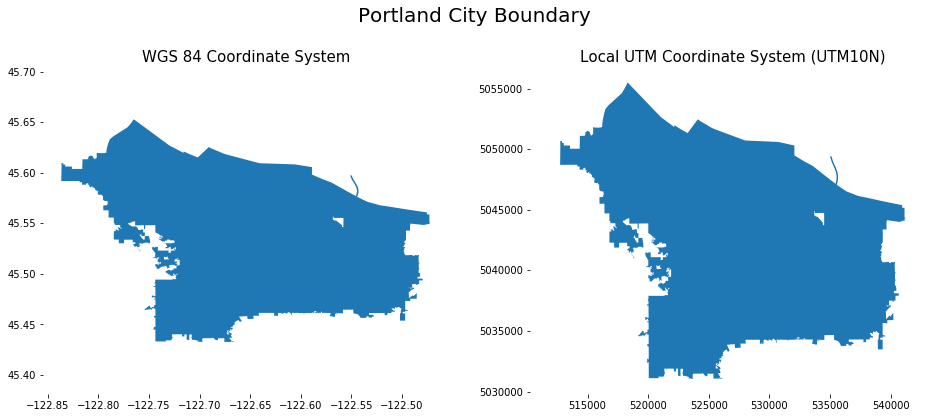

In [6]:
# Define parameters of the city
city = 'Portland'
query = 'Portland, Oregon, United States' # Use for OSM query
crs = {'init': 'epsg:26910'}

# Define function to download boundary (cache return)
@memory.cache
def download_city_boundary(query):
    print('Downloading OSM Boundary')
    return ox.gdf_from_place(query) 

# Download boundary
# download_city_boundary.clear() # Uncomment to clear cache and force recompute
boundary_gdf = download_city_boundary(query)

# Set up figure for comparing city boundary in WGS and UTM 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6))
fig.suptitle('Portland City Boundary', size=20, y=1.02)

# Plot boundary in WGS
boundary_gdf.plot(ax=ax1)
ax1.set_title('WGS 84 Coordinate System', size=15)
ax1.set_frame_on(False)
ax1.axis('equal')

# Plot boundary in UTM
boundary_gdf.to_crs(crs).plot(ax=ax2)
ax2.set_title('Local UTM Coordinate System (UTM10N)', size=15)
ax2.set_frame_on(False)
ax2.axis('equal')
plt.show()

Now let's use this boundary to download OSM data. Depending on how large an area we download, and how many OSM features are contained within it, OSMmx may return multiple Overpass JSONs to reduce memory load. I wrote a convenience function to aquire these JSONs, merge them, save them to disk, and then load them back from disk if already downloaded.

In [7]:
# Extract polygon from boundary geodataframe
boundary = boundary_gdf.at[0,'geometry']
        
# Define tag filter
# Importantly, no paths with 'highway':'service' or 'highway':'motorway' tags will be returned
tag_filter = ('["area"!~"yes"]["highway"!~"service|footway|motor|proposed|construction|abandoned|platform|raceway"]'
              '["bicycle"!~"no"]["access"!~"private"]')

# Define function to download OSM JSON (cache return)
@memory.cache(ignore=['boundary'])
def download_osm_json(boundary, tag_filter):
    print('Downloading OSM JSON')
    overpass_jsons = ox.osm_net_download(boundary, custom_filter=tag_filter)
    overpass_json = sp.merge_overpass_jsons(overpass_jsons)
    return overpass_json

# Download OSM JSON
# download_osm_json.clear() # Uncomment to clear cache and force recompute
overpass_json = download_osm_json(boundary, tag_filter)

### Investigate OSM Data Structure

The JSON is structured a single-element dictionary with `'elements'` as the only key, and a list of geometric elements as the value. There are over 350,000 elements in the Portland dataset, each of them either a node (point) or way (linestring). The vast majority are nodes, because linestrings must be formed by connecting nodes.

In [8]:
total = len(overpass_json['elements'])
print('total elements: {}'.format(total))

nodes = len([x for x in overpass_json['elements'] 
             if x['type'] == 'node'])
print('nodes: {} ({}%)'.format(nodes, round(nodes / total * 100)))
    
ways = len([x for x in overpass_json['elements'] 
            if x['type'] == 'way'])
print('ways: {} ({}%)'.format(ways, round(ways / total * 100)))

total elements: 185102
nodes: 157825 (85%)
ways: 27277 (15%)


Each element has a unique `'id'` and a `'type'`. *Nodes* have longitudes and latitutes. They may also have `'tags'`, which specify attributes. This *node*, for example, has traffic signals.

In [9]:
overpass_json['elements'][7:8]

[{'id': 27526567,
  'lat': 45.5120085,
  'lon': -122.7790996,
  'tags': {'highway': 'crossing'},
  'type': 'node'}]

*Way* geometries are defined by lists of node IDs. Their attributes are also specified by tags. This way is a `'secondary'` highway and also has tags specifying lane count, speed limit, sidewalks, and bicyle facilities. `'bicycle': 'designated'` indicates that this is a designated bicycle route, but doesn't indicate a specific type of facility. `'cycleway': 'lane'`, however, indicates that there is a bike lane.

In [10]:
overpass_json['elements'][-45:-44]

[{'id': 586135745,
  'nodes': [40586060,
   1396610644,
   4916021243,
   40685049,
   4916021242,
   4916076961,
   4916076962,
   4916076960,
   4922880281,
   40685053,
   4922880280,
   4922880284,
   40607139,
   4922880285,
   4922880289,
   40685058,
   4922880288,
   4917804678,
   40685061],
  'tags': {'bicycle': 'designated',
   'cycleway': 'no',
   'highway': 'tertiary',
   'lanes': '2',
   'maxspeed': '25 mph',
   'name': 'Northeast Knott Street',
   'oneway': 'no',
   'sidewalk': 'both'},
  'type': 'way'}]

How many different tags are available on these nodes and ways?

In [11]:
node_tags, way_tags = osm.examine_tags(overpass_json, )
print('Unique tags on nodes: {}'.format(len(node_tags)))
print('Unique tags on ways: {}'.format(len(way_tags)))

Unique tags on nodes: 76
Unique tags on ways: 237


However, most elements don't have any tags, and very few have many tags:

In [12]:
def tag_stats(title, tag_counts):
    print(title)
    print('  Count: {}'.format(len(num_tags)))
    print('  Avg tag count: {0:.2f}'.format(np.mean(num_tags)))
    print('  Std dev of tag count: {0:.2f}'.format(np.std(num_tags)))
    print('  Max tag count: {}\n'.format(np.max(num_tags)))
    
num_tags = [len(element['tags']) if 'tags' in element else 0 
            for element in overpass_json['elements']]
tag_stats('All elements:', num_tags)
    
num_tags = [len(element['tags'])  
            for element in overpass_json['elements'] if
            (('tags' in element) and (element['type']=='node'))]
tag_stats('Nodes with at least one tag:', num_tags)

num_tags = [len(element['tags'])  
            for element in overpass_json['elements'] if
            (('tags' in element) and (element['type']=='way'))]
tag_stats('Ways with at least one tag:', num_tags)

All elements:
  Count: 185102
  Avg tag count: 1.14
  Std dev of tag count: 2.68
  Max tag count: 20

Nodes with at least one tag:
  Count: 14825
  Avg tag count: 1.28
  Std dev of tag count: 0.51
  Max tag count: 10

Ways with at least one tag:
  Count: 27277
  Avg tag count: 7.02
  Std dev of tag count: 2.65
  Max tag count: 20



Let's look at what tags are available on ways for identifying bicycle facilities, which OSM calls "cycleways."  

Cycleways may be tagged using the `'cyclway'` key and derivitive subkeys that begin with `'cyclway'` and append suffixes seperated by colons. We can use a regular expression to search for any key with this pattern.

In [13]:
_, way_tags = sp.examine_tags(overpass_json, ['^cycleway(:\w+)?$'])
way_tags

{'cycleway': {'crossing': 9,
  'lane': 2750,
  'no': 83,
  'opposite': 3,
  'opposite_lane': 14,
  'proposed': 28,
  'share_busway': 9,
  'shared_lane': 770,
  'track': 23},
 'cycleway:backward': {'lane': 1},
 'cycleway:both': {'no': 27},
 'cycleway:left': {'lane': 139,
  'opposite_lane': 11,
  'proposed': 1,
  'share_busway': 2,
  'shared_lane': 20,
  'track': 2},
 'cycleway:right': {'lane': 159, 'no': 4, 'shared_lane': 21, 'track': 1},
 'cycleway:source': {'http://bikeportland.org/2011/09/01/a-ride-along-on-the-newly-completed-rosa-parks-bikeway-project-58449#more-58449': 15}}

Nearly 3,000 *ways* are tagged with `'cycleway':'lane'`, and a handful more have the `'lane'` value with `'cycleway:*'` subkeys. We can see that it will be important to parse the following keys:
- `'cycleway'`
- `'cycleway:backward'`
- `'cycleway:both'`
- `'cycleway:left'`
- `'cycleway:right'`

with any of the following values:
- `'lane'`
- `'opposite'`
- `'opposite_lane'`
- `'share_busway'`
- `'shared_lane'`
- `'track'`. 

Off-street cycleways with have their own rights-of-way are instead tagged using  `'highway':'cycleway'`. Conveniently, there aren't any `'highway'` subkeys to worry about.

Just over 300 ways are off-street cycleways.

In [14]:
_, way_tags = sp.examine_tags(overpass_json, ['^highway(:\w+)?$'])
way_tags

{'highway': {'bus_stop': 2,
  'cycleway': 322,
  'elevator': 1,
  'living_street': 105,
  'path': 1583,
  'pedestrian': 138,
  'primary': 1969,
  'primary_link': 147,
  'residential': 15336,
  'secondary': 2254,
  'secondary_link': 120,
  'steps': 740,
  'street_lamp': 1,
  'tertiary': 3652,
  'tertiary_link': 61,
  'track': 128,
  'trunk': 349,
  'trunk_link': 158,
  'unclassified': 211}}

### Parse Cycleway Data

Now that we've know what tags we're looking for, we have to parse them into specific types of bicycle facilities. In theory, there could be more than one type of facility on each way, so we'll make dummy variables for each type.

In [15]:
# Define bikeway columns and associated labels
bikeway_types = [
    'off_street_path',
    'bike_blvd',
    'separated_bike_lane',
    'bike_lane',
    'shoulder',
    'sharrow',
    'bike_route']

# Parse Overpass JSON into bikeway types
overpass_parsed = osm.parse_osm_tags(
    overpass_json, bikeway_types, 
    true_value=1, false_value=0, none_value=np.nan)

for bikeway_type in bikeway_types:
    _, way_tags = osm.examine_tags(overpass_json, [bikeway_type])
    print(way_tags)

{'off_street_path': {nan: 26955, 1: 322}}
{'bike_blvd': {nan: 27172, 1: 105}}
{'separated_bike_lane': {nan: 27251, 1: 26}}
{'bike_lane': {1: 3066, nan: 24211}}
{'shoulder': {nan: 27277}}
{'sharrow': {nan: 26466, 1: 811}}
{'bike_route': {1: 9004, nan: 18273}}


This gives us 3,025 ways with bike lanes, and 9,099 with bike routes. Other facility types of much less represented in the OSM dataset.

### Rectangularize Street Data

These data are still, however, stored in a JSON-style tree structure, which is inconvenient for analysis. The spatial units of the ways are also inconsistent. If the attributes of a street are highly variable over its length, the street may be represented by many seperate ways, each with its own attribute structure. Conversely, if attributes remain consistent over a long distance, many blocks may be represented by a single way. To provide a more consistent unit of analysis, we will restructure the ways into block-length segments. This will require merging some ways, and breaking others into pieces.

The OSMnx function, `create_graph`, parses the Overpass JSON into a graph representation of edges and nodes, breaking OSM ways so into segments between intersections.

`simplify_graph` aggregates edges within the same block so that every edge represents a single block-length street segment. 

By default, the graph created by `create_graph` is directional, meaning that each edge represents only a single direction of flow between two nodes. This means that two-way streets are represented by duplicate edges facing in opposite directions. We aren't using the graph for routing, so we can ignore directionality and simplify our graph to undirected edges using the NetworkX function, `to_undirected`, thus reducing the number of edges in our dataset by almost half.

Finally, we *rectangularize* our data by converting the graph to GeoDataFrames using the `graph_to_gdfs` function. This gives us a seperate GeoDataFrame for edges and nodes, with columns for each of our facility types. We could have converted to GeoDataFrames before parsing the facility types, but we would have needed to create columns for every tag necessary to identify identify the facilities. With this approach, our resulting GeoDataFrames are a tidy summary of only the variables in which we're interested.

In [16]:
# Define function to convert OSM JSON to GeoDataFrames 
# with simplified edges (cache return)
@memory.cache(ignore=['json'])
def osm_json_to_geodataframe(json, way_tags, crs):
    print('Converting JSON to GeoDataFrame')
    # Set tags that will be extracted for wayss
    ox.config(useful_tags_path=way_tags)
    # Convert json to networkx graph
    G = ox.create_graph([json])
    # Simply graph by removing all nodes that are not intersections or dead ends 
    G = ox.simplify_graph(G, strict=True)
    # Make graph undirected
    G = nx.to_undirected(G)
    # Convert graph edges to geodataframe
    osm_edges = ox.graph_to_gdfs(G, nodes=False)
    # Project to local coordinate system 
    osm_edges = osm_edges.to_crs(crs)
    return osm_edges

# Specify tags to include for each edge
way_tags = (bikeway_types + ['ref', 'highway', 'name'])

# Convert JSON to GeoDataFrame
# osm_json_to_geodataframe.clear() # Uncomment to clear cache and force recompute
osm_edges = osm_json_to_geodataframe(overpass_parsed, way_tags, crs)
    
# Show transposed head of the GeoDataFrame to preview structure
osm_edges.head().T.rename_axis('Column', axis=1)

Column,0,1,2,3,4
bike_blvd,NaN,NaN,NaN,NaN,NaN
bike_lane,NaN,NaN,NaN,NaN,NaN
bike_route,NaN,NaN,1,NaN,NaN
geometry,LINESTRING (526421.9828931309 5042776.80028018...,LINESTRING (526421.9828931309 5042776.80028018...,LINESTRING (526421.9828931309 5042776.80028018...,LINESTRING (526414.3314840356 5042776.80135905...,LINESTRING (526414.3314840356 5042776.80135905...
highway,primary,primary,residential,primary,primary
key,0,0,0,0,0
length,19.294,76.331,7.633,76.316,19.224
name,Northeast Martin Luther King Junior Boulevard,Northeast Martin Luther King Junior Boulevard,Northeast Tillamook Street,Northeast Martin Luther King Junior Boulevard,Northeast Martin Luther King Junior Boulevard
off_street_path,NaN,NaN,NaN,NaN,NaN
oneway,False,False,False,False,False


The Overpass API returns elements that intersect the convex hull of the city boundary, so many of our edges still fall outside the boundary in places where it is concave. Let's constrain the edges to the city boundary. Note that edges which straddle the city city boundary are still included. 

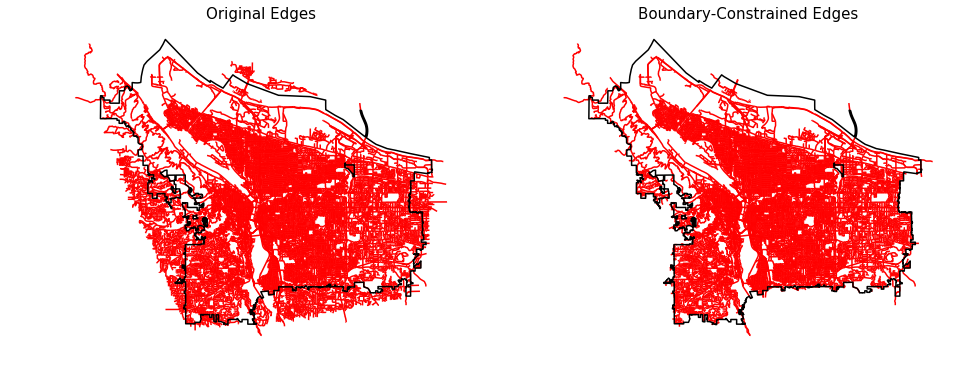

In [17]:
# Project city boundary to local coordinate system
boundary_gdf = boundary_gdf.to_crs(crs)

# Constrain edges to those intersecting the city boundary polygon
osm_edges_constrained = sp.gdf_intersecting_polygon(
    osm_edges, boundary_gdf.at[0, 'geometry'])

# Set up figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6))

# Plot original edges
ax1.set_title('Original Edges', size=15)
sp.plot_shapes([(boundary_gdf.boundary, {'color':'k'}),
                (osm_edges, {'color':'r'})], ax=ax1)

# Plot boundary-constrained edges
ax2.set_title('Boundary-Constrained Edges', size=15)
sp.plot_shapes([(boundary_gdf.boundary, {'color':'k'}), 
                (osm_edges_constrained, {'color':'r'})], ax=ax2)

# Replace original edges with the constrained version
osm_edges = osm_edges_constrained

Many edges, because they are aggregated from multiple OSM elements, have multiple attributes stored in lists. For example, these edges have multiple `bike_lane` attributes. Apparently, some portions of the edge have a bike lane, while others do not.

In [18]:
# Identify rows with multiple bike lane values
bike_lane_is_list = [
    i for i, x in enumerate(osm_edges['bike_lane']) 
    if isinstance(x, list)]

# Preview these rows
osm_edges[['bike_lane','osmid']].iloc[
    bike_lane_is_list].head().rename_axis('Edge ID', axis=1)

Edge ID,bike_lane,osmid
21446,"[nan, 1]","[5535322, 118773479]"
21445,"[nan, 1]","[5536640, 52560731, 118773480, 194437328]"
2708,"[nan, 1]","[194437322, 117467627, 5528039]"
20135,"[nan, 1]","[5525010, 47183860]"
2185,"[nan, 1]","[40998306, 418903915, 418903916, 107732565]"


Let's collapse these lists into binary values describing whether *any* portion of the edge has a bike lane.

In [19]:
# Summarize lists
osm_edges[bikeway_types] = osm_edges[bikeway_types].applymap(
    lambda x: sp.nan_any(x, 1, np.nan))

# Preview results
osm_edges[['bike_lane','osmid']].iloc[bike_lane_is_list].head().rename_axis('Edge ID', axis=1)

Edge ID,bike_lane,osmid
21446,1.0,"[5535322, 118773479]"
21445,1.0,"[5536640, 52560731, 118773480, 194437328]"
2708,1.0,"[194437322, 117467627, 5528039]"
20135,1.0,"[5525010, 47183860]"
2185,1.0,"[40998306, 418903915, 418903916, 107732565]"


We also want to simplify the highway classifications so we can use them to select certain edges for analysis and interpret our results. For example, we can ignore freeways, known in OSM as "motorways", where bicycle facilities will never exist.

Due to the aggregation of OSM elements, many edges also have more than one highway class. 

In [20]:
# Show example values in the 'highway' column
list(set([str(x) for x in osm_edges['highway'].tolist()]))[:10]

["['secondary_link', 'cycleway']",
 'secondary',
 'primary',
 'living_street',
 "['cycleway', 'residential']",
 'trunk',
 'residential',
 "['steps', 'path']",
 "['primary_link', 'tertiary']",
 "['residential', 'secondary']"]

We want to select the class representing the largest type of highway, the type *least* likely to be comfortable for bicyclists. This ensures that highway classes provide a conservative estimate of *bikability*.

We can also collapse some classes together, for example `primary` and `primary_link` can be collapsed into `primary` without any loss of specificity for our purposes.

Other classes, such as `street_lamp` (an example of tagging that does not conform with OSM guidelines), are meaningless for our purposes, and can be reclassified as `other`.

In [21]:
# Define a function to select the largest available highway type
def largest_highway(highways):
    # Specify highway order, 
    # largest (least bikable) to smallest (most bikable)
    highway_order = [ 
        'trunk',
        'primary',
        'secondary',
        'tertiary',
        'unclassified',
        'residential',
        'living_street',
        'cycleway']
    highways = sp.listify(highways)
    
    # Strip '_link' from tags
    highways = [x[:-5] if x[-5:] == '_link' else x for x in highways]
    
    # If list includes one of these tags, return the biggest one    
    ranked_highways = [x for x in highways if x in highway_order]    
    if len(ranked_highways) > 0:
        ranks = [highway_order.index(x) for x in ranked_highways]
        return highway_order[min(ranks)]
    
    # Otherwise, return 'other'
    else:
        return 'other'

# Apply simpification function across the highway column
osm_edges['highway'] = osm_edges['highway'].apply(largest_highway)

Highway classes now conform to our simplified structure.

In [22]:
# Count simplified highway values
pd.DataFrame(osm_edges['highway'].value_counts())

,highway
residential,20992
tertiary,5265
secondary,2459
primary,1955
other,1649
trunk,351
cycleway,302
unclassified,278
living_street,25


Now we can select only the highway types that are bikable.

In [23]:
# Define bikable highway types
bikable = [
    'primary',
    'secondary',
    'tertiary',
    'unclassified',
    'residential',
    'living_street',
    'cycleway']

# Restrict edges to records with these values
osm_edges = osm_edges[osm_edges['highway'].isin(bikable)].copy()

Finally, let's select the best cycleway (the one that will be most comfortable for cyclists) available on each edge. There might be more than one type of bikeway on each edge, so we'll use a nested conditional statement to select the best available option.

In [24]:
# Define function to select the best available bikeway type
def best_bikeway(row):
    if row['off_street_path'] == 1:
        return 'off_street_path'
    elif row['bike_blvd'] == 1:
        return 'bike_blvd'
    elif row['separated_bike_lane'] == 1:
        return 'separated_bike_lane'
    elif row['bike_lane'] == 1:
        return 'bike_lane'
    elif row['shoulder'] == 1:
        return 'shoulder'
    elif row['sharrow'] == 1:
        return 'sharrow'
    elif row['bike_route'] == 1:
        return 'bike_route'
    else:
        return np.nan

# Apply best cycleway function across edges
osm_edges['bikeway'] = osm_edges.apply(best_bikeway, axis=1)

Let's see how the OSM bikeways are distributed throughout the city.

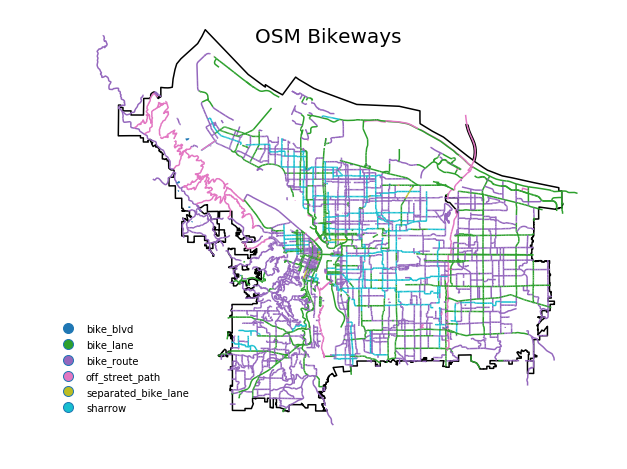

In [25]:
# Initiate figure
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('OSM Bikeways', size=20, y=0.85)

# Plot city boundary
sp.plot_shapes((boundary_gdf.boundary, {'color':'k'}), ax=ax)

# Plot bikeways
osm_edges[osm_edges['bikeway'].notnull()].plot(
    column='bikeway', legend=True, ax=ax)
ax.set_axis_off()
ax.get_legend().set_bbox_to_anchor((0, 0, 0.25, 0.3))
ax.get_legend().draw_frame(False)

## 2. Join Bikeways from a local source

### Load Local Bikeways

To assess the representativeness of these OSM bikeways, we need to load data from a local source, which we will use as a point of comparison. Oregon Metro provides a Shapefile of Portland-area bicycle facilities on their [online data portal](http://rlisdiscovery.oregonmetro.gov/). Let's load this shapefile and see how it matches up with the OSM data.

In [26]:
# Load shapefile
local_edges = gpd.read_file('bikeway_shapefiles/Portland/bike_routes.shp')

# Project to local coordinate system
local_edges = local_edges.to_crs(crs)

# Restrict to edges intersecting the boundary of Portland
local_edges = sp.gdf_intersecting_polygon(
    local_edges, boundary_gdf.at[0, 'geometry'])

# Preview columns
local_edges.head().T.rename_axis('Column', axis=1)

Column,100351,100818,83197,83188,83031
BIKEID,110113,110149,197062,197063,114500
NAME,NW 35TH AVE,NW 53RD DR,None,None,NW BARNES RD
BIKETYP,None,None,None,None,None
BIKETHERE,None,None,None,None,LT
F_ZLEV,1,1,1,1,1
T_ZLEV,1,1,1,1,1
LENGTH,412.028,1161.33,463.2,244.829,122.543
geometry,LINESTRING (521940.5024988113 5043248.13137867...,LINESTRING (520272.2571325405 5043177.00358640...,LINESTRING (520735.6779111713 5040800.44381937...,LINESTRING (520735.6779111713 5040800.44381937...,LINESTRING (521305.3465827153 5040858.02293568...


The `BIKETYP` column contains the bikeway classes. Let's reference the local bikeways [metadata](http://rlisdiscovery.oregonmetro.gov/metadataviewer/display.cfm?meta_layer_id=3312) to recode these into the same types we identified in the OSM data.

Unfortunatly, this requires losing some precision in the local bikeway classification because OSM does not adequatly differentiate between different types of *off street paths* (e.g., regional, local, or under/overpasses) or *separated bike lanes* (e.g., buffered lanes and cycle tracks). To faciliate comparison, we will adopt OSM's simpler classifications.

In [27]:
# Specify reclassifications
bikeway_recode = {
    'BKE-LANE': 'bike_lane',
    'PTH-LOMU': 'off_street_path',
    'PTH-REMU': 'off_street_path',
    'BKE-BLVD': 'bike_blvd',
    'BKE-BUFF': 'separated_bike_lane',
    'BKE-SHRD': 'sharrow',
    'SHL-WIDE': 'shoulder',
    'OTH-XING': 'off_street_path',
    'BKE-TRAK': 'separated_bike_lane',
    'OTH-CONN': 'sharrow'}

# Map the dictionary to the bikeway column
local_edges['bikeway'] = local_edges['BIKETYP'].map(bikeway_recode)

Already, we can see that the two datasets are quite different. There are far fewers local bikeways than OSM bikeways. In particular, the local classification scheme does not include bike routes, which make up the majority of the OSM cycleways. The local data also include many more off-street paths.

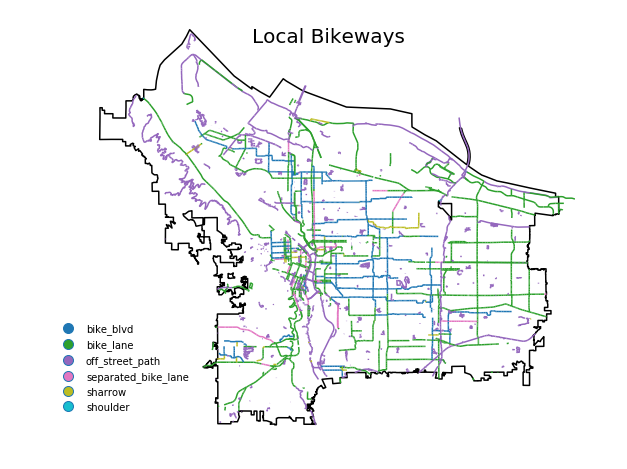

In [28]:
# Plot local bikeways
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Local Bikeways', size=20, y=0.85)

sp.plot_shapes((boundary_gdf.boundary, {'color':'k'}), ax=ax)
_ = local_edges[local_edges['bikeway'].notnull()].plot(
    column='bikeway', legend=True, ax=ax)

ax.get_legend().set_bbox_to_anchor((0, 0, 0.25, 0.3))
ax.get_legend().draw_frame(False)

If we overlay the local and OSM bikeways and zoom in, we can also see that their geometries don't perfectly align. This poses challenges for relating the two datasets.

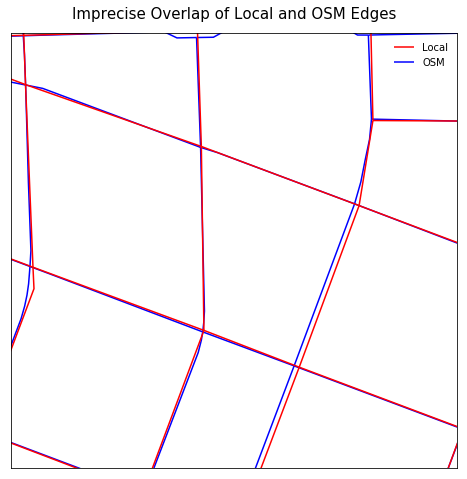

In [29]:
# Buffer a point downtown
downtown = sh.geometry.Point(525000, 5041000).buffer(100).bounds

# Overlay the local and osm edges within this downtown area 
_, ax = sp.plot_shapes(
    [(local_edges, {'color':'red', 'legend':'Local'}),
     (osm_edges, {'color':'blue', 'legend':'OSM'})], 
    extent=downtown)
ax.set_title('Imprecise Overlap of Local and OSM Edges', size=15, y=1.02)
ax.get_legend().draw_frame(False)

Our goal is to transfer information from the local dataset onto the OSM dataset, allowing us to compare bikeway types within the same spatial units.

The process of relating similar but not precisely equal entities is called [*conflation*](http://wiki.gis.com/wiki/index.php/Conflation). Conflation of geo-datasets can draw on geometric similarities, attribute similiarities, or both, to identify which feature(s) in one dataset best match a feature in another. We will focus on geometric similarity to identify initial matches, and attribute similarity to check our results.

### Two Aproaches for Geometric Conflation

Let's experiment with two potential approaches for conflation. To start with, we'll use some sample datasets that pose some typical conflation challenges.

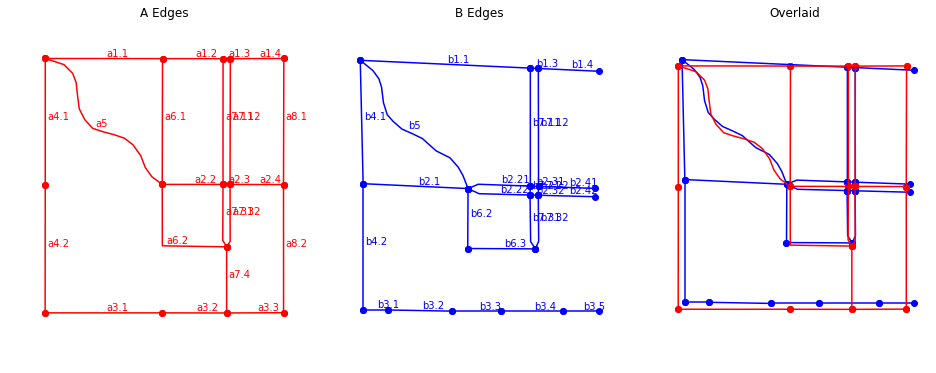

In [30]:
# Load sample edges
a_edges = gpd.read_file('bikeway_shapefiles/minimal_example/a.shp')
b_edges = gpd.read_file('bikeway_shapefiles/minimal_example/b.shp')

# Plot edges separatly and together
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16,6))
ax1.set_title('A Edges')
sp.plot_shapes([(a_edges, {'color': 'r', 'label': 'name'}),
                ([endpoint for edge in a_edges.geometry 
                      for endpoint in sp.endpoints(edge)], {'color': 'r'})
               ], ax=ax1)
ax2.set_title('B Edges')
sp.plot_shapes([(b_edges, {'color': 'b', 'label': 'name'}),
                ([endpoint for edge in b_edges.geometry 
                      for endpoint in sp.endpoints(edge)], {'color': 'b'})
               ], ax=ax2)

ax3.set_title('Overlaid')
sp.plot_shapes([(a_edges, {'color': 'r'}),
                ([endpoint for edge in a_edges.geometry 
                      for endpoint in sp.endpoints(edge)], {'color': 'r'}),
                (b_edges, {'color': 'b'}),
                ([endpoint for edge in b_edges.geometry 
                      for endpoint in sp.endpoints(edge)], {'color': 'b'}),
                
               ], ax=ax3)

Many, but not all of the segments in *A* are related to segments in *B*. In fact, there are several types of relations:


| <p align="left">Relation | <p align="left">Description | <p align="left">Example (~ donotes similiarity) |
| --- | --- | --- |
| <p align="left">1:1 | <p align="left">1 segment in A is related to 1 segment in B | <p align="left">*a4.1* ~ *b4.1* |
| <p align="left">1:0 | <p align="left">1 segment in A is related to 0 segments in B | <p align="left">*a8.2* |
| <p align="left">0:1 | <p align="left">0 segments in A are related to 1 segments in B | <p align="left">*b2.1* |
| <p align="left">1:n | <p align="left">1 segment in A is related to several segments in B | <p align="left">*a6.2* ~ {*b6.3*, *b6.3*} |
| <p align="left">m:1 | <p align="left">several segments in A are related to 1 segment in B | <p align="left">{*a1.1*, *a1.2*} ~ *b1.1* |
| <p align="left">m:n | <p align="left">several segments in A are related to several segments in B | <p align="left">{*a3.1*, *a3.2*, *a3.3*} ~ {*b3.1*, *b3.2*, *b3.2*, *b3.3*, *b3.4*, *b3.5*} |

In some cases, a single segment in A can also have multiple 1:1 relationships with segments in B. For example, *a2.2* ~ *b2.21* and *a2.2* ~ *b2.22*

How can we identify all of these various relationships?

#### Midpoint Distance

A straighforward approach is to find the midpoints of all the features in one dataset, then find the closest feature to each of these midpoints in the second dataset.

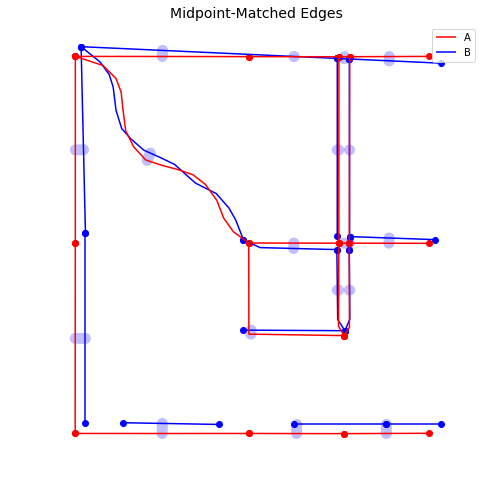

In [31]:
# Find matches for a_edges among b_edges based on distance from a_edges midpoints
a_matches = conflation.match_lines_by_midpoint(
    a_edges, b_edges, distance_tolerance=20, 
    match_fields=True, match_vectors=True)

# Define a function to plot results of the match
def plot_match_results(a_matches, b_edges, ax=None):
    # Interpret custom name fields, if specified
    if isinstance(a_matches, tuple):
        a_matches, a_name = a_matches
    else:
        a_name = 'name'
    if isinstance(b_edges, tuple):
        b_edges, b_name = b_edges
    else:
        b_name = 'name_match'
    # Reduce to matched edges
    a_matches = a_matches[a_matches[b_name].notnull()]
    a_nodes = [endpoint for edge in a_matches.geometry
               for endpoint in sp.endpoints(edge)]
    
    # Identify matched b_edges and nodes  
    b_match_names = []
    for name in a_matches[b_name]:
        if isinstance(name, list):
            b_match_names.extend(name)
        elif pd.notnull(name):
            b_match_names.append(name)
    b_matches = b_edges[b_edges['name'].isin(b_match_names)]  
    b_nodes = [endpoint for edge in b_matches.geometry 
               for endpoint in sp.endpoints(edge)]
    
    # Convert match vectors into a geodataframe so they can be buffered
    ab_vectors = []
    for vector in a_matches['match_vectors']:
        if isinstance(vector, list):
            ab_vectors.extend(vector)
        elif pd.notnull(vector):
            ab_vectors.append(vector)
    ab_vectors = gpd.GeoDataFrame(geometry=ab_vectors) 
    
    # Plot results
    _, ax = sp.plot_shapes([
        (a_matches, {'color': 'r', 'legend':'A'}),
        (a_nodes, {'color': 'r'}), 
        (b_matches, {'color': 'b', 'legend':'B'}),
        (b_nodes, {'color': 'b'}),
        (ab_vectors.buffer(5), {'color':'b', 'alpha':0.25})], 
        ax=ax, legend=['Target Edge', 'Match Edge', ''])
    
    return ax

# Plot results
ax = plot_match_results(a_matches, b_edges)
ax.set_title('Midpoint-Matched Edges', size=14)
plt.show()

The semi-transparent blobs in the figure above show matches made between the midpoint of *A* segment and the closest *B* segment. This approach works ok with 1:1, 1:0, and m:1 relations, where there's only one possible *B* segment to match with each *A* segment. It struggles with 1:n and m:n relations, where it makes sense to match multiple B segments to a single A segment.

#### Hausdorff Distance

[Hausdorff distances](https://en.wikipedia.org/wiki/Hausdorff_distance) provide another, slightly more sophisticated approach for assessing similarity between features. The Hausdorff distance between one feature, *a*, and another, *b*, is calculated by finding the shortest distance from any point on *a* to *b*, then taking the maximum of these shortest distances. Essentially, it summarizes the maximum distance that *a* and *b* ever are from one another.

Hausdorff distances are directional, meaning that the Hausdorff distance from *a* to *b* can be different than that from *b* to *a*. For example, take lines *a* and *b*, below, which are spaced 1 unit apart. The maximum shortest distance to *b* from any point on *a* is 1, but the maximum shortest distance to *a* from any point on *b* is 3.16. As described by [Li and Goodchild (2011)](https://www.tandfonline.com/doi/abs/10.1080/19479832.2011.577458), we can use this discrepancy to identify that *a* is approximatly a subset of *b*. In other words, the relationship between *a* and *b* is m:1 because *a* relates to only a portion of *b*.

Hausdorff distance from:
    a to b: 1.00
    b to a: 3.16


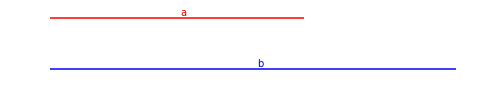

In [32]:
# Define and plot example lines
a = sh.geometry.LineString([(0,1), (5,1)])
b = sh.geometry.LineString([(0,0), (8,0)])
_, _ = sp.plot_shapes(
    [(a, {'color':'r', 'label':'a'}), 
     (b, {'color':'b', 'label':'b'})], size=(8,1.25))
print('Hausdorff distance from:')
print('    a to b: {0:.2f}'.format(sp.directed_hausdorff(a, b)))
print('    b to a: {0:.2f}'.format(sp.directed_hausdorff(b, a)))

If we match our sample segments *A* and *B* based on Hausdorff distances we see that multiple *B* edges are matched to some *A* segments, forming 1:n and m:n relationships.

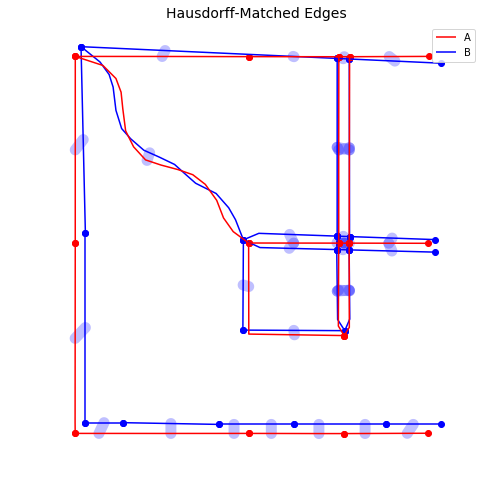

In [33]:
a_matches = conflation.match_lines_by_hausdorff(
    a_edges, b_edges,
    distance_tolerance=20,
    match_fields=True,
    field_suffixes=('_a','_b'),
    match_vectors=True,
    match_stats=True)

# Plot results
ax = plot_match_results((a_matches, 'name_a'), (b_edges, 'name_b'))
ax.set_title('Hausdorff-Matched Edges', size=14)
plt.show()

Some *A* segments also have 1:1 relationships with multiple *B* segments, such as where two parallel lines are used to represent each direction of large roads. Each of the *A* segments *a2.2-4* and *a7.1-3* are matched along its full length to multiple parallel *B* segments. Actually, *a2.3* is somewhat erroneously matched to 4 *B* segments, including two that cross it perpendicularly. This is due to all of these segments being shorter than the 20 unit Hausdorff distance tolerance, so even the perpendicular segments are considered close.  

In [34]:
(a_matches[['name_a','name_b','match_type']][a_matches['name_a'].isin(
    ['a2.2', 'a2.3', 'a2.4', 'a7.11', 'a7.12', 'a7.31', 'a7.32'])]).sort_values('name_a')

,name_a,name_b,match_type
5,a2.2,"[b2.22, b2.21]",1:1
21,a2.3,"[b7.21, b2.32, b2.31, b7.22]",1:1
12,a2.4,"[b2.42, b2.41]",1:1
6,a7.11,"[b7.11, b7.12]",1:1
19,a7.12,"[b7.11, b7.12]",1:1
17,a7.31,"[b7.31, b7.32]",1:1
18,a7.32,"[b7.31, b7.32]",1:1


We can solve the issue with *a2.3* by comparing the azimiths of the primary axes of the target and match features, and only allowing a match if these azimuths are reasonably similar. In this example, we specify that the azimith difference cannot be more than 20 degrees. Now *a2.3* matches with only the segments that are parallel to it.

In [35]:
a_matches = conflation.match_lines_by_hausdorff(
    a_edges, b_edges,
    distance_tolerance=20,
    azimuth_tolerance=20,
    match_fields=True,
    field_suffixes=('_a','_b'),
    match_vectors=True,
    match_stats=True)

(a_matches[['name_a','name_b','match_type']][a_matches['name_a'].isin(
    ['a2.2', 'a2.3', 'a2.4', 'a7.11', 'a7.12', 'a7.31', 'a7.32'])]).sort_values('name_a')

,name_a,name_b,match_type
5,a2.2,"[b2.22, b2.21]",1:1
21,a2.3,"[b2.32, b2.31]",1:1
12,a2.4,"[b2.42, b2.41]",1:1
6,a7.11,"[b7.11, b7.12]",1:1
19,a7.12,"[b7.11, b7.12]",1:1
17,a7.31,"[b7.31, b7.32]",1:1
18,a7.32,"[b7.31, b7.32]",1:1


We can further check the reasonablness of a match based on the coorespondance of attribute information, such as names. We'll use a package called [*fuzzywuzzy*](https://github.com/seatgeek/fuzzywuzzy) that examines how well two strings match one another based on the [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance).

For example, the similarity of two identical strings is 100%:

In [36]:
def string_similarity(a, b):
    similarity = fuzz.token_set_ratio(a, b)
    print("'{}' and '{}' are {}% similar".format(a, b, similarity))
string_similarity('a2.4', 'a2.4')

'a2.4' and 'a2.4' are 100% similar


If we one out of four characters is different, the strings are 75% similar:

In [37]:
string_similarity('a2.4', 'b2.4')

'a2.4' and 'b2.4' are 75% similar


And if we add an additional character to one string, their similarity goes down slightly:

In [38]:
string_similarity('a2.4', 'b2.42')

'a2.4' and 'b2.42' are 67% similar


With real street names, this fuzzy string matching is helpful for identifying similarity between slight misspellings or abbreviations that a person would understand as equivalents, but a computer would consider unequal.

In [39]:
string_similarity('College St', 'Collige Street')

'College St' and 'Collige Street' are 75% similar


We can further improve matching by standardizing common abbreviations based on the US Postal Service's [Addressing Standards](https://pe.usps.com/text/pub28/welcome.htm).

In [40]:
a = 'College St'
a = sp.conflation.standardize_streetname(a)
print('preprocessed a = {}'.format(a))
b = 'Collige Street'
b = sp.conflation.standardize_streetname(b)
print('preprocessed b = {}'.format(b))
string_similarity(a, b)

preprocessed a = College St
preprocessed b = Collige St
'College St' and 'Collige St' are 90% similar


Let's use fuzzy string matching to compare the 'name' columns in our sample datasets.

In [41]:
a_matches = conflation.match_lines_by_hausdorff(
    a_edges, b_edges,
    distance_tolerance=20,
    azimuth_tolerance=20,
    match_fields=True,
    field_suffixes=('_a','_b'),
    match_vectors=True,
    match_stats=True)

(a_matches[['name_a','name_b','match_type']][a_matches['name_a'].isin(
    ['a2.2', 'a2.3', 'a2.4', 'a7.11', 'a7.12', 'a7.31', 'a7.32'])]).sort_values('name_a')

,name_a,name_b,match_type
5,a2.2,"[b2.22, b2.21]",1:1
21,a2.3,"[b2.32, b2.31]",1:1
12,a2.4,"[b2.42, b2.41]",1:1
6,a7.11,"[b7.11, b7.12]",1:1
19,a7.12,"[b7.11, b7.12]",1:1
17,a7.31,"[b7.31, b7.32]",1:1
18,a7.32,"[b7.31, b7.32]",1:1


To keep our data tidy, so that there is a maximum of one match for each record (rather than lists of matches for 1:n or m:n relationships), we can expand the target features into sub-segments that correspond to specific match segments.

In [42]:
a_matches = conflation.match_lines_by_hausdorff(
    a_edges, b_edges,
    distance_tolerance=20,
    azimuth_tolerance=20,
    match_strings=('name','name'),
    field_suffixes=('_a','_b'),
    match_vectors=True,
    match_stats=True,
    expand_target_features=True)

(a_matches[['name_a','name_b','match_type']][a_matches['name_a'].isin(
    ['a2.2', 'a2.3', 'a2.4', 'a7.11', 'a7.12', 'a7.31', 'a7.32'])]).sort_values('name_a')

,name_a,name_b,match_type
26,a2.2,b2.22,1:1
27,a2.2,b2.21,1:1
43,a2.3,b2.32,1:1
44,a2.3,b2.31,1:1
32,a2.4,b2.42,1:1
33,a2.4,b2.41,1:1
28,a7.11,b7.11,1:1
29,a7.11,b7.12,1:1
41,a7.12,b7.11,1:1
42,a7.12,b7.12,1:1


If we plot these expanded segments, we see that the *A* features were also broken geometrically into segments corresponding to the extents of the *B* features with which they matched.

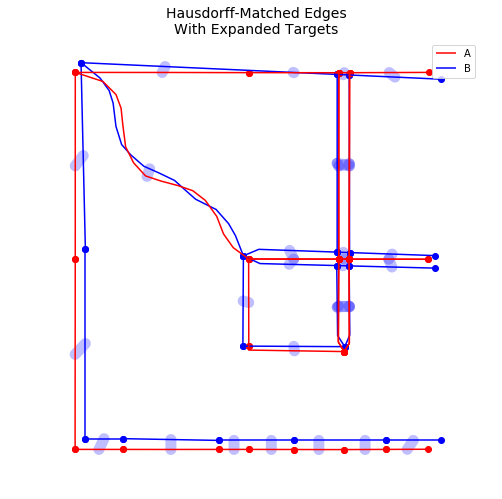

In [43]:
ax = plot_match_results((a_matches, 'name_a'), (b_edges, 'name_b'))
ax.set_title('Hausdorff-Matched Edges\nWith Expanded Targets', size=14)
plt.show()

Now that we've developed some tools for matching datasets, let's use them to match the local bikeway edges with the OSM edges throughout Portland.

First, we'll make sure our local and OSM edges have similar fields so they'll be easy to compared once they're matched. The OSM edges already have dummy fields for each of the bikeway types. Let's make dummies for the local edges, too.

We'll also make the street name column lowercase so it's consistent with the OSM edges.

Finally, we'll remove all records without any bikeways to reduce the number of potential matches.

In [44]:
# Break bikeway column into dummy variables
local_edges = sp.insert_dummies(local_edges, 'bikeway', drop_field=False, zero_value=np.nan)

# Make `NAME` column lower case for consistency
local_edges = local_edges.rename(columns={'NAME':'name'})

# Exclude edges without bikeways 
local_edges = local_edges[local_edges['bikeway'].notnull()]

print('{} edges to match'.format(len(local_edges)))

9327 edges to match


To reduce clutter in the output, we'll restrict the columns for both input datasets to the bikeway variables.

In [45]:
@memory.cache(ignore=['osm_edges','local_edges'])
def match_local_to_osm_edges(osm_edges, local_edges):
    print('Computing OSM-Local Matches')
    osm_matches = conflation.match_lines_by_hausdorff(
        osm_edges,
        local_edges,
        constrain_target_features=True,
        distance_tolerance=20,
        azimuth_tolerance=20,
        match_fields=True,
        match_strings=('name_osm','name_local'))
    return osm_matches

# Assemble dataframes with specific columns for matching
analysis_columns = bikeway_types + ['name', 'geometry']
osm_edges_for_matching = sp.select_columns(
    osm_edges, analysis_columns, suffix='_osm').rename(
        columns={'geometry_osm':'geometry'})
local_edges_for_matching = sp.select_columns(
    local_edges, analysis_columns, suffix='_local').rename(
        columns={'geometry_local':'geometry'})

# Compute matches
# match_local_to_osm_edges.clear() # Uncomment to clear cache and force recompute
osm_matches = match_local_to_osm_edges(
    osm_edges_for_matching, local_edges_for_matching)

# Preview head of resulting dataframe
osm_matches.head().T.rename_axis('Column', axis=1)

Column,6003,2269,12547,33738,33739
off_street_path_osm,NaN,NaN,NaN,NaN,NaN
bike_blvd_osm,NaN,NaN,NaN,NaN,NaN
separated_bike_lane_osm,NaN,NaN,NaN,NaN,NaN
bike_lane_osm,NaN,NaN,NaN,NaN,NaN
shoulder_osm,NaN,NaN,NaN,NaN,NaN
sharrow_osm,NaN,NaN,NaN,NaN,NaN
bike_route_osm,1,NaN,NaN,NaN,NaN
name_osm,Northwest Pittock Avenue,NaN,Northwest Seblar Drive,Northwest Seblar Drive,Northwest Seblar Terrace
match_type,NaN,NaN,NaN,NaN,NaN
match_id,NaN,NaN,NaN,NaN,NaN


We analyzed consistency between the OSM and local street names, but in many cases, one or the other did not have a name, resulting in a null string comparison. Rather than excluding these records, we will ignore the string comparisons and assume that records matched appropriatly based on their geometries.

In [46]:
string_comp_prop = (len(osm_matches['match_strings'].dropna()) / 
                    len(osm_matches['match_strings']) * 100)

print('Only {0:.2f}% of edges have valid string comparisons.'.format(string_comp_prop))

Only 15.27% of edges have valid string comparisons.


## 3. Analyze consistency (or lack thereof) between OSM and local bikeways

Now that the local bikeways are conflated to the OSM edges, we can analyze the degree to which they represent bikeways similarly.

First, we must simplify the 1:n and m:n matches so that there is a single value for each local match. We did not use the `expand_target_features` parameter on the `match_lines_by_hausdorff` function because we didn't want to fragment the geometries of the OSM edges. Instead, we just want to know if there are *any* local bikeways associated with each OSM edge.

We'll map a function over the records to return a dummy `1` if a bikeway column contains a list, and that list contains *any* value of `1`.

In [47]:
# Preview record with list matches
pd.DataFrame(osm_matches.loc[2251])

,2251
off_street_path_osm,NaN
bike_blvd_osm,NaN
separated_bike_lane_osm,NaN
bike_lane_osm,1
shoulder_osm,NaN
sharrow_osm,NaN
bike_route_osm,1
name_osm,Northeast Weidler Street
match_type,1:1
match_id,93635


In [48]:
# Identify local and osm bikeway columns
joint_bikeway_columns = [column for column in osm_matches.columns if 
                         any(bikeway in column for bikeway in bikeway_types)]

# Function to summarize lists as 1 if any value is 1 
def summarize_matches(cell):
    output = np.nan
    if cell == 1:
        output = 1
    elif isinstance(cell, list):
        if any(pd.notnull(cell)):
            output = 1
    return output

# Map function over bikeway columns
osm_matches[joint_bikeway_columns] = osm_matches[joint_bikeway_columns].applymap(summarize_matches)

# Preview output
pd.DataFrame(osm_matches.loc[2251])

,2251
off_street_path_osm,NaN
bike_blvd_osm,NaN
separated_bike_lane_osm,NaN
bike_lane_osm,1
shoulder_osm,NaN
sharrow_osm,NaN
bike_route_osm,1
name_osm,Northeast Weidler Street
match_type,1:1
match_id,93635


Now, we'll restrict the dataframe to edges with at least one OSM or local bikeway. We'l also calculate the length of each edge to use as a summary statistic, and reclassify `np.nan` values as `0` to facilitate cross-tabulation.

In [49]:
# Record the number of edges in the original osm dataset
orig_n = len(osm_matches)

# Drop records without any bikeway in either dataset
osm_matches = osm_matches.dropna(how='all', subset=joint_bikeway_columns)

# Calculate the length of each edge to use as a summary statistic
osm_matches['length'] = osm_matches['geometry'].apply(lambda x: x.length)

# Reclassify NaN values
osm_matches = osm_matches.fillna(0)

# Record the number of edges with a bikeway of some type
bikeway_n = len(osm_matches)

print(
    ('{} out of {} edges have a bike facility in one or more '
     'of the datasets').format(bikeway_n, orig_n))

11341 out of 31276 edges have a bike facility in one or more of the datasets


Finally, let's investigate whether edges that have bikways according to the OSM dataset also have bikeways according to the local dataset, and *vice versa*. To do this, we'll cross-tabulate by facility according to each dataset, and then summarize the results as a count of edges, and the total length of those edges.

In [50]:
# Make a function to cross-tabulate based on two columns and summarize based on a third
def summarize_facility(df, summary_columns, summary_labels=['OSM', 'Local'], 
                       data_labels={1: 'Bike Lane', 0: 'No Bike Lane'}, 
                       agg_columns=['length'], agg_funcs=[len, sum], 
                       agg_labels=['Edges', 'Total Length (km)'],
                       agg_postprocess=[lambda x: x.astype(int), 
                                        lambda x: (x / 1000).round(1)]):
    # Select columns to summarize by
    summary = df[summary_columns].copy()
    # Rename columns
    summary.columns = summary_labels
    # Reclassify values
    summary = summary.apply(lambda column: column.map(data_labels), axis=0)   
    # Add aggregation values
    summary = summary.merge(df[agg_columns], left_index=True, right_index=True)   
    # Summarize the aggregation values by the summary columns
    summary = pd.pivot_table(
        summary,
        index=summary_labels, 
        values=agg_columns,
        aggfunc=agg_funcs)    
    # Drop the second level of the column index
    summary.columns = summary.columns.droplevel(1)
    # Rename the columns
    summary.columns = agg_labels
    # Postprocess the aggregations
    for column, process in zip(agg_labels, agg_postprocess):
        summary[column] = process(summary[column])
    return summary

# Summarize bike lanes
bike_lane_summary = summarize_facility(
    osm_matches, 
    summary_columns=['bike_lane_osm', 'bike_lane_local'],
    summary_labels=['OSM', 'Local'])

bike_lane_summary

Edges  Total Length (km)
OSM          Local                                 
Bike Lane    Bike Lane      2527              301.6
             No Bike Lane    495               54.7
No Bike Lane Bike Lane       192               17.1
             No Bike Lane   8127              970.4

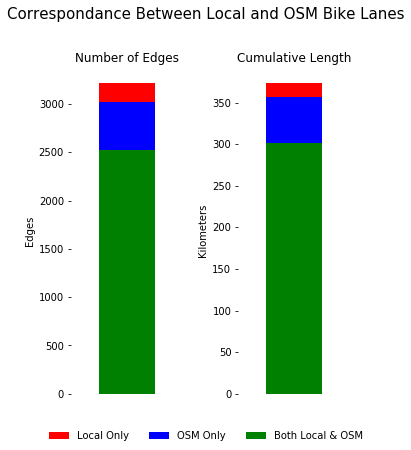

In [51]:
# Initialize a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(5,6))
fig.suptitle('Correspondance Between Local and OSM Bike Lanes', size=15, y=1.02)

# Adjust spacing between subplots 
plt.subplots_adjust(wspace=.5)

# Plot counts
counts = bike_lane_summary[['Edges']].iloc[:-1]
counts.T.plot(
    kind='bar', stacked=True, title='Number of Edges',
    color=['g','b','r'], legend=False, ax=ax1)
ax1.set_ylabel('Edges')
ax1.get_xaxis().set_visible(False)
ax1.set_frame_on(False)
# ax1.xaxis.set_tick_params(rotation=0)

# Plot lengths
lengths = bike_lane_summary[['Total Length (km)']].iloc[:-1]
lengths.T.plot(
    kind='bar', stacked=True, title='Cumulative Length', 
    color=['g','b','r'], legend=False, ax=ax2)
ax2.set_ylabel('Kilometers')
ax2.get_xaxis().set_visible(False)
ax2.set_frame_on(False)
# ax2.xaxis.set_tick_params(rotation=0)

# Make legend
handles, _ = ax1.get_legend_handles_labels()
fig.legend(
    reversed(handles), 
    ['Local Only', 'OSM Only', 'Both Local & OSM'], 
    loc='lower center', ncol=3).draw_frame(False)
plt.show()

OSM and the local dataset largely agree in their representation of bike lanes. Among edges with a bike lane desigation in either dataset (3,192 edges), the two datasets agreed on nearly 80% (2,527 edges). About 15% (495 edges) were designated as a bike lane by OSM, but not by the local dataset. The last 5% (170 edges) had bike lanes according to the local dataset, but not OSM.

Let's apply this analysis across the other types of bike facilities to see how they compare.

In [52]:
# Attach labels to bikeway types 
bikeway_labels = [
    'Off Street Path',
    'Bike Boulevard',
    'Separated Bike Lane',
    'Bike Lane',
    'Shoulder',
    'Sharrow',
    'Bike Route']
bikeway_labels = OrderedDict(zip(bikeway_types, bikeway_labels))

# Calculate summaries for each bikeway type
summaries = compare_bikeways.summarize_bikeway_correspondance(osm_matches, bikeway_labels)

summaries

Off Street Path         Bike Boulevard          \
                                Edges  Length          Edges  Length   
OSM        Local                                                       
Bikeway    Bikeway                169    66.0            NaN     NaN   
           No Bikeway             157    26.4           25.0     1.7   
No Bikeway Bikeway                392    61.1         1288.0   125.2   
           No Bikeway           10623  1190.3        10028.0  1216.9   

                      Separated Bike Lane         Bike Lane        Shoulder  \
                                    Edges  Length     Edges Length    Edges   
OSM        Local                                                              
Bikeway    Bikeway                     27     2.6      2527  301.6      NaN   
           No Bikeway                  19     1.0       495   54.7      NaN   
No Bikeway Bikeway                    248    28.4       192   17.1      5.0   
           No Bikeway               11047  1311.8      8127  970.4  11336.0   

                              Sharrow         Bike Route          
                       Length   Edges  Length      Edges  Length  
OSM        Local                                                  
Bikeway    Bikeway        NaN     111    10.9        NaN     NaN  
           No Bikeway     NaN    1622   152.9    10543.0  1248.6  
No Bikeway Bikeway        3.0      56     5.9        NaN     NaN  
           No Bikeway  1340.7    9552  1174.0      798.0    95.2

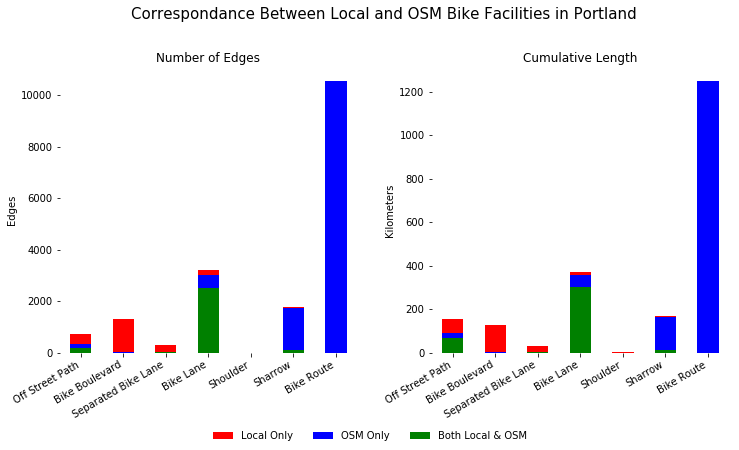

In [53]:
# Plot summaries
compare_bikeways.plot_local_osm_comparison(summaries, city)

There appears to be a some lack of correspondance between the Local and OSM bikeway types. For example, the OSM dataset doesn't have many separated bike lanes, but it has more regular bike lanes than the Local dataset. Perhaps we will see more similarity if we generalize into broader categories that might be more consistently identified:
- *exclusive bikeways*: space that is exclusively for cyclists
    - e.g., bike lanes and separated bike lanes
- *shared bikeways*: space shared between cyclists and vehicles
    - e.g., bike boulevards, sharrows, and bike routes
- *any bikeway*: any type of bikeway

In [54]:
# Calculate new columns identifying exclusive bikeways
def composite_columns(matches, columns, suffix):
    return sp.select_columns(
        matches, [x + suffix for x in columns]).apply(
            lambda x: 1 if any(x) else 0, axis=1)

# Define exclusive and shared bikeway types
exclusive_bikeways = ['bike_lane','separated_bike_lane']
shared_bikeways = ['bike_blvd','sharrow','bike_route']

# Calculate composite of exclusive bikeways
osm_matches['exclusive_bikeway_osm'] = composite_columns(
    osm_matches, exclusive_bikeways, '_osm')
osm_matches['exclusive_bikeway_local'] = composite_columns(
    osm_matches, exclusive_bikeways, '_local')

# Calculate composite of shared bikeways
osm_matches['shared_bikeway_osm'] = composite_columns(
    osm_matches, shared_bikeways, '_osm')
osm_matches['shared_bikeway_local'] = composite_columns(
    osm_matches, shared_bikeways, '_local')

# Calculate composite of all bikeways
osm_matches['any_bikeway_osm'] = composite_columns(
    osm_matches, bikeway_types, '_osm')
osm_matches['any_bikeway_local'] = composite_columns(
    osm_matches, bikeway_types, '_local')

# Add labels for composite bikeway types
bikeway_labels.update({'exclusive_bikeway':'Exclusive'})
bikeway_labels.update({'shared_bikeway':'Shared'})
bikeway_labels.update({'any_bikeway':'Any'})

# Recalculate summaries with these columns
summaries = compare_bikeways.summarize_bikeway_correspondance(
    osm_matches, bikeway_labels)

summaries[['Exclusive','Shared','Any']]

Exclusive        Shared             Any       
                          Edges Length  Edges  Length   Edges Length
OSM        Local                                                    
Bikeway    Bikeway         2747  325.1   1420   139.5  4585.0  560.5
           No Bikeway       317   34.6   9335  1126.4  6469.0  749.0
No Bikeway Bikeway          230   20.9     35     2.5   287.0   34.2
           No Bikeway      8047  963.1    551    75.3     NaN    NaN

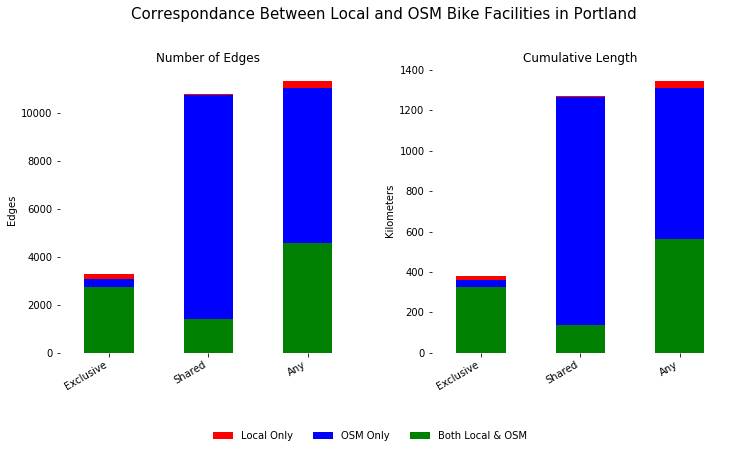

In [55]:
compare_bikeways.plot_local_osm_comparison(summaries[['Exclusive','Shared','Any']], city)

There are 287 edges along which there is local bike facility, but no OSM facility. What kinds of facilities does the local dataset show along these edges?

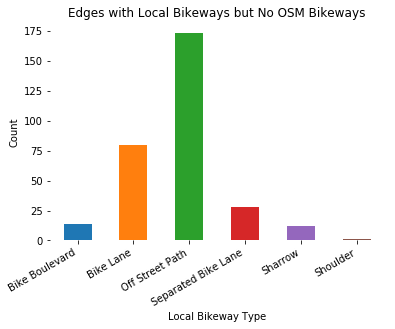

In [56]:
# Select rows where there is only a bikeway specified in the local dataset
local_only = osm_matches[(
    (osm_matches['any_bikeway_local'] == 1) & 
    (osm_matches['any_bikeway_osm'] == 0))]

# Select columns for local bikeways 
local_bikeway_columns = [x + '_local' for x in bikeway_labels.keys()][:-3]
# local_bikeway_columns = local_bikeway_columns + ['length']
local_only = sp.select_columns(local_only, local_bikeway_columns)

# Sum each column
local_only = local_only.sum()

# Collect labels for each bikeway type 
local_only = pd.Series(
    {bikeway_labels[label.rstrip('_local')]:int(value) 
     for label, value in local_only.iteritems()})

# Plot results
ax = local_only.plot(kind='bar', title='Edges with Local Bikeways but No OSM Bikeways')
ax.set_ylabel('Count')
ax.set_xlabel('Local Bikeway Type')
ax.set_frame_on(False)
ax.set_xticklabels(local_only.index, rotation=30, ha='right')
plt.show()

Now let's pull this whole process into a single function, `compare_bikeways.analyze_city`, so we can iterate the analysis across a few cities. We'll wrap this in a local function in `compare_osm_and_local_bikeways` to cache the results.

From the results in Portland, San Francisco, and New York (below), we can see that the representativeness of OSM bikeways fluctuates between cities, but generally hovers around 75% of bikeways included in local datasets. Portland has many more streets with bikeways that are only listed by OSM compared with the other cities. Chiefly, OSM lists a very large number of streets as "bike routes". If we evalute only 'exclusive' bikeways, such as bike lanes, local-OSM correspondance. This trend is shared across all of the cities.

In [57]:
@memory.cache(ignore=['local_edges'])
def compare_osm_and_local_bikeways(city, boundary, crs, local_edges):
    print('Computing {} Summaries'.format(city))
    summaries, osm_matches = compare_bikeways.analyze_city(
        boundary=boundary, 
        crs=crs, 
        local_edges=local_edges)
    return summaries, osm_matches

### Portland, Oregon

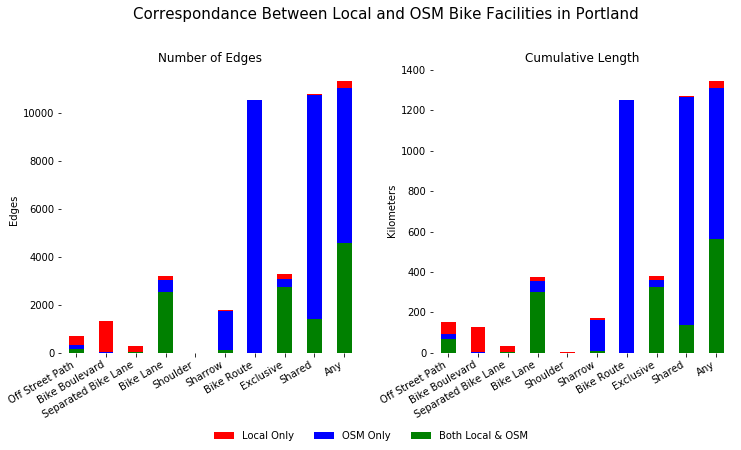

In [58]:
# Download boundary polygon
def download_portland_boundary():
    # Download OSM boundary
    boundary = ox.gdf_from_place(
        'Portland, Oregon, United States')
    # Extract geometry
    boundary = boundary.at[0,'geometry']
    return boundary

# Classify bikeways in Portland Shapefile
def classify_portland_bikeways(row):
    if row['BIKETYP'] in ['PTH-LOMU', 'PTH-REMU', 'OTH-XING']:
        return 'off_street_path'
    elif row['BIKETYP'] in ['BKE-BLVD']:
        return 'bike_blvd'
    elif row['BIKETYP'] in ['BKE-BUFF', 'BKE-TRAK']:
        return 'separated_bike_lane'
    elif row['BIKETYP'] in ['BKE-LANE']:
        return 'bike_lane'
    elif row['BIKETYP'] in ['SHL-WIDE']:
        return 'shoulder'
    elif row['BIKETYP'] in ['BKE-SHRD', 'OTH-CONN']:
        return 'sharrow'
    else:
        return np.nan

# Compare OSM and Local Bikeways
# compare_osm_and_local_bikeways.clear() # Uncomment to clear cache and force recompute
portland_summaries, portland_matches = compare_osm_and_local_bikeways(
    city='Portland',
    boundary=download_portland_boundary(), 
    crs={'init': 'epsg:26910'}, # UTM 10N
    local_edges=compare_bikeways.structure_bikeways_shapefile(
        shp_path='bikeway_shapefiles/Portland/bike_routes.shp',
        classification_function=classify_portland_bikeways,
        name_column='NAME'))

# Plot results
compare_bikeways.plot_local_osm_comparison(portland_summaries, 'Portland')

### San Francisco, California

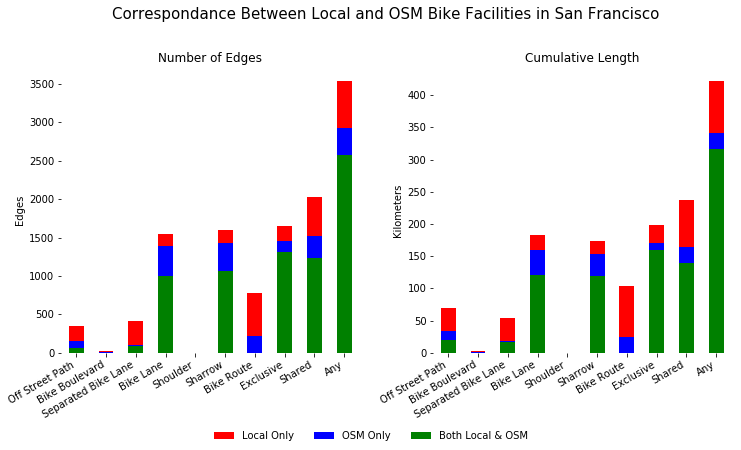

In [59]:
# Download boundary polygon
def download_sf_boundary():
    # Download OSM boundary
    boundary = ox.gdf_from_place(
        'San Francisco City and County, California, United States of America')
    # Extract geometry
    boundary = boundary.at[0,'geometry']
    # Select second of two polygons in multipolygon
    boundary = [x for x in boundary][1]
    return boundary

# Classify bikeways in San Francisco Shapefile
def classify_sf_bikeways(row):
    if row['facility_t'] == 'CLASS I':
        return 'off_street_path'
    elif row['symbology'] == 'NEIGHBORWAY':
        return 'bike_blvd'
    elif ((row['facility_t'] == 'CLASS IV') or 
          (row['buffered'] == 'YES') or
          (pd.notnull(row['barrier'])) or
          (row['raised'] == 'YES')):
        return 'separated_bike_lane'
    elif row['facility_t'] == 'CLASS II':
        return 'bike_lane'
    elif row['sharrow'] > 0:
        return 'sharrow'
    elif row['symbology'] == 'BIKE ROUTE':
        return 'bike_route'
    else:
        return np.nan

# Compare OSM and Local Bikeways
# compare_osm_and_local_bikeways.clear() # Uncomment to clear cache and force recompute
sf_summaries, sf_matches = compare_osm_and_local_bikeways(
    city='San Francisco',
    boundary=download_sf_boundary(), 
    crs={'init': 'epsg:26910'}, # UTM 10N  
    local_edges=compare_bikeways.structure_bikeways_shapefile(
        shp_path='bikeway_shapefiles/San_Francisco/SanFranciscoBikeways.shp',
        classification_function=classify_sf_bikeways,
        name_column='street'))

# Plot results
compare_bikeways.plot_local_osm_comparison(sf_summaries, 'San Francisco')

### New York, New York

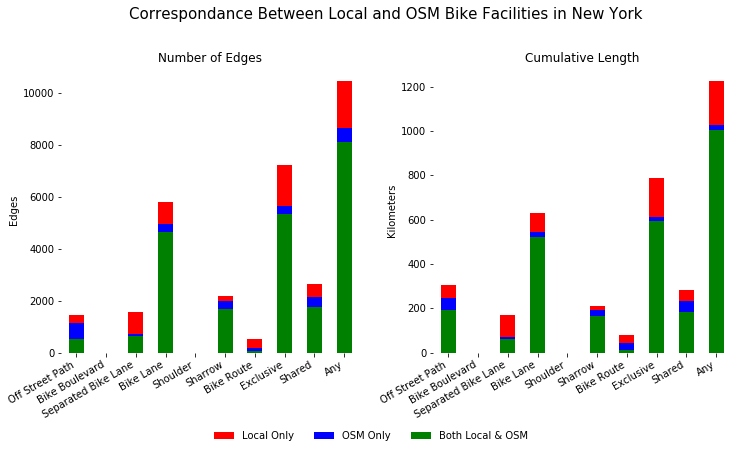

In [60]:
# Download boundary polygon
def download_nyc_boundary():
    # Download OSM boundary
    boundary = ox.gdf_from_place(
        'New York City, New York, United States of America')
    # Extract geometry
    boundary = boundary.at[0,'geometry']
    # Select second of two polygons in multipolygon
    boundary = [x for x in boundary][0]
    return boundary

# Classify bikeways in  New York Shapefile
def classify_nyc_bikeways(row):
    # See if any bikeway field contains a certain bikeway
    def any_bikeway(bikeway):
        bikeway_fields = [row['ft_facilit'], row['tf_facilit']]
        return any([bikeway in x if x is not None else False 
                    for x in bikeway_fields])   
    # Test for bikeway types in descending order
    if(
        any_bikeway('Greenway') or
        any_bikeway('Boardwalk') or
        any_bikeway('Ped Plaza') or
        any_bikeway('Dirt Trail')):
        return 'off_street_path'
    elif(
        any_bikeway('Buffered Conventional') or
        any_bikeway('Protected Path')):
        return 'separated_bike_lane'
    elif( 
        any_bikeway('Bike-Friendly Parking') or
        any_bikeway('Curbside') or
        any_bikeway('Standard')):
        return 'bike_lane'
    elif(
        any_bikeway('Sharrow')):
        return 'sharrow'
    elif(
        any_bikeway('Signed Route')):
        return 'bike_route'
    else:
        return np.nan

# Compare OSM and Local Bikeways
# compare_osm_and_local_bikeways.clear() # Uncomment to clear cache and force recompute
nyc_summaries, nyc_matches = compare_osm_and_local_bikeways(
    city='New York',
    boundary=download_nyc_boundary(), 
    crs={'init': 'epsg:26918'}, # UTM 18N 
    local_edges=compare_bikeways.structure_bikeways_shapefile(
        shp_path='bikeway_shapefiles/New_York/NewYorkBikeways.shp',
        classification_function=classify_nyc_bikeways,
        name_column='street'))

# Plot results
compare_bikeways.plot_local_osm_comparison(nyc_summaries, 'New York')

## Appendix: Key Challenges Presented by OSM Data

Here is a more in-depth description of two primary challenges faced by users of OSM data. In this project, we developed some strategies for controlling certain aspects of these challenges. Ultimatly, however, users of OSM data must interpret the results of their analyses with these caveats in mind.

### *Completeness*

Completeness refers to the extent to which on-the-ground features are represented in the database. When OpenStreetMap began in 2004, it was essentially a *tabula rasa*. Features needed to be added by users in order to be "on the map." This continues to result in vast potential for *false negatives*: something that doesn't appear to exist based on the dataset, but actually exists on the ground. This extends to both geometries and attributes. For example, imagine a street with a bike lane that exists in the real world. If this street were not mapped at all in OSM, this would constitute a *false negative*. However, what if the street was mapped as a centerline, but without an attribute specifying that it had a bike lane? The street geometry would be a *true positive*—the street does exist along that centerline—but the lack of a bike lane attribute constitutes a *false negative*. We don't know whether the bike lane actually doesn't exist, or is simply missing from the map. Issues with geometric and attribute completeness are not unique to OSM, but they are amplified by OSM's lack of editorial oversight and piecemeal contributions. Bulk imports to the OSM database, such as the importing of [TIGER street centerlines](https://wiki.openstreetmap.org/wiki/TIGER) across the United States in 2007, have made coverage of certain features fairly complete. However, features that are not readily available from National- and State-level sources, such as bicycle infrastructure, still rely heavily on municipal and individual contributors, and are thus quite variable in their degree of completeness.

### *Consistency*

Challenges related to *consistency* are rooted in the variety of ways that OSM contributors can define and record both geometric and attribute information. The OSM community has developed [guidelines](https://wiki.openstreetmap.org/wiki/Category:Tagging_guidelines) for specifying geometries and attributes, and strong norms have developed for how to map common features. Nonetheless, there are no rigidly-enforced standards. Among contributors who map bicycle facilities, for example, there are two philosophies about how to represent off-street paths paralleling a street, often referred to as "sidepaths." One camp recommends that they be recorded as attributes of the street itself, sharing the same geometric centerline. The other recommends that they be represented by a second, parallel centerline. Both have their merits for analyses with different purposes and scales. OSM users, however, must expect sidepaths to be represented in either geometric form and develop systems to account for both.

Attribute inconsistencies pose a similar, though arguably even more formidable challenge. The high degree of variabilty in OSM attributing is due to its tree-based *tag* schema (much like GeoJSON), which theoretically allows for infinite combinations of *keys* and *values* for each geometric feature. A line feature might, for example, be tagged as ``'highway'='residential'``, indicating that it is a residential street, and also ``'cycleway'='lane'``, indicating that it has an on-street bike lane. Key suffixes may also be used to provide more detail. For example, `'cycleway:left'='lane'` would indicate that there is a bike lane on the left-hand side of the street. Due to such permutations, answering a conceptually simple question like, "is there a bike lane on this street?," requires examining multiple keys, including ``{'cycleway', 'cycleway:backward', 'cycleway:right', 'cycleway:left', 'cycleway:both'}``, for any of a handful common values representing different types of facilities, including  ``{'lane', 'opposite_lane', 'track', 'opposite_track', 'buffered_lane', 'shared_lane', 'shared_busway', 'shoulder'}``. Assessing all of the  ``'cycleway'`` tag's [248 unique values](https://taginfo.openstreetmap.org/keys/cycleway#values) would be a practical impossibilty, but investigating which tags are most used in a particular geography may help avoid inadvertantly ignoring valuable information. Even so, missing or ill-defined attributes pose a persistent challenge.